## Clustering - based on RFM analysis


_**RFM**: stands for recency, frequency, monetary value. In business analytics, we often use this concept to divide customers into different segments, like high-value customers, medium value customers or low-value customers, and similarly many others._

- **Recency:** How recently has the customer made a transaction with us <br />
- **Frequency:** How frequent is the customer in ordering/buying some product from us <br />
- **Monetary:** How much does the customer spend on purchasing products from us.<br />

Source: [_RFM Analysis Using Python._ GeeksForGeeks](https://www.geeksforgeeks.org/rfm-analysis-analysis-using-python/)

In [35]:
# relevant modules

import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
import sklearn
import datetime as dt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from collections import Counter
from sklearn.metrics import silhouette_score

In [2]:
# reading file with source data to continue cluster exercise 
df = pd.read_csv('Processed_data.csv' , sep=',')

In [3]:
# new dataframe grouping customers and summing sales per customer (Sales will total the customer spenditure defined above as the monetary component of the RFM analysis)

df_monetary = df.groupby('CustomerID', as_index=False)['Sales'].sum()
df_monetary.head()

,CustomerID,Sales
0,AA-10315,556354.0
1,AA-10375,105636.0
2,AA-10480,179051.0
3,AA-10645,508690.0
4,AB-10015,88615.0


In [4]:
# adjusting sales from cents by dividing by 100 

df_monetary['Sales'] = df_monetary['Sales'] / 100 
df_monetary.head()

,CustomerID,Sales
0,AA-10315,5563.54
1,AA-10375,1056.36
2,AA-10480,1790.51
3,AA-10645,5086.90
4,AB-10015,886.15


In [5]:
# creating a frequency column for customers
frequency = df['CustomerID'].value_counts()

df_monetary['Frequency'] = df_monetary['CustomerID'].map(frequency)

In [6]:
df_monetary.head()

,CustomerID,Sales,Frequency
0,AA-10315,5563.54,11
1,AA-10375,1056.36,15
2,AA-10480,1790.51,12
3,AA-10645,5086.90,18
4,AB-10015,886.15,6


In [7]:
# adding the  recency column

# Convert 'OrderDate' to datetime format
df['OrderDate'] = pd.to_datetime(df['OrderDate'])

# Define the reference date as today
reference_date = pd.Timestamp(dt.datetime.today().date())

# Group by 'CustomerID' and get the most recent 'OrderDate' for each customer
df_last_order = df.groupby('CustomerID')['OrderDate'].max().reset_index()

# Calculate the recency in days
df_last_order['Recency'] = (reference_date - df_last_order['OrderDate']).dt.days

# after the recency is calculated it is now mapped to the DF used for clustering
mapping = dict(df_last_order[['CustomerID', 'Recency']].values)
df_monetary['Recency'] = df_last_order.CustomerID.map(mapping)
print(df_monetary)

    CustomerID    Sales  Frequency  Recency
0     AA-10315  5563.54         11     2519
1     AA-10375  1056.36         15     2354
2     AA-10480  1790.51         12     2594
3     AA-10645  5086.90         18     2390
4     AB-10015   886.15          6     2750
..         ...      ...        ...      ...
788   XP-21865  2374.62         28     2378
789   YC-21895  5454.34          8     2339
790   YS-21880  6720.43         12     2344
791   ZC-21910  8025.63         31     2389
792   ZD-21925  1493.93          9     2537

[793 rows x 4 columns]


**Outlier removal**

In [9]:
# function to drops outliers across desired features  

def drop_iqr_outliers(df, col_name, whisker=1.5):
  """
  This function drops outliers from a specific column in a pandas dataframe based on IQR.

  Args:
      df (pandas.DataFrame): The dataframe containing the data.
      col_name (str): The name of the column to check for outliers.
      whisker (float, optional): The multiplier for IQR to define outlier boundaries. Defaults to 1.5.

  Returns:
      pandas.DataFrame: The dataframe with outliers removed from the specified column.
  """
  Q1 = df[col_name].quantile(0.25)
  Q3 = df[col_name].quantile(0.75)
  IQR = Q3 - Q1
  lower = Q1 - whisker * IQR
  upper = Q3 + whisker * IQR
  outliers = (df[col_name] < lower) | (df[col_name] > upper)
  return df.loc[~outliers]

In [10]:
# List of features to check for outliers

# reviewing original shape and storing a copy of data with outliers
print("Original Shape: ", df_monetary.shape)
df_monetary_w_outliers = df_monetary.copy()

features_to_check = ["Sales", "Frequency", "Recency"]

for feature in features_to_check:
  df_monetary = drop_iqr_outliers(df_monetary.copy(), feature)

print("New Shape: ", df_monetary.shape)



Original Shape:  (793, 4)
New Shape:  (663, 4)


**Plotting data to visualize distribution**

In [19]:
import matplotlib.pyplot as plt

def plot_individual_boxplots(df, features_to_plot, title="Individual Boxplots"):
  """
  This function plots separate boxplots for each feature in a pandas dataframe.

  Args:
      df (pandas.DataFrame): The dataframe containing the data.
      features_to_plot (list): A list of feature names to plot boxplots for.
      title (str, optional): The title for the overall plot. Defaults to "Individual Boxplots".
  """
  plt.figure(figsize=(12, 6))  # Adjust figure size as needed
  n_plots = len(features_to_plot)
  for i, feature in enumerate(features_to_plot):
    plt.subplot(1, n_plots, i+1)  # Create subplots for each feature
    df.boxplot(column=feature)
    plt.xlabel(feature)
    plt.ylabel("Values")
    plt.title(f"{feature} Boxplot")
    plt.grid(True)
  plt.suptitle(title)  # Set overall title for the figure
  plt.tight_layout()  # Adjust spacing between subplots
  plt.show()



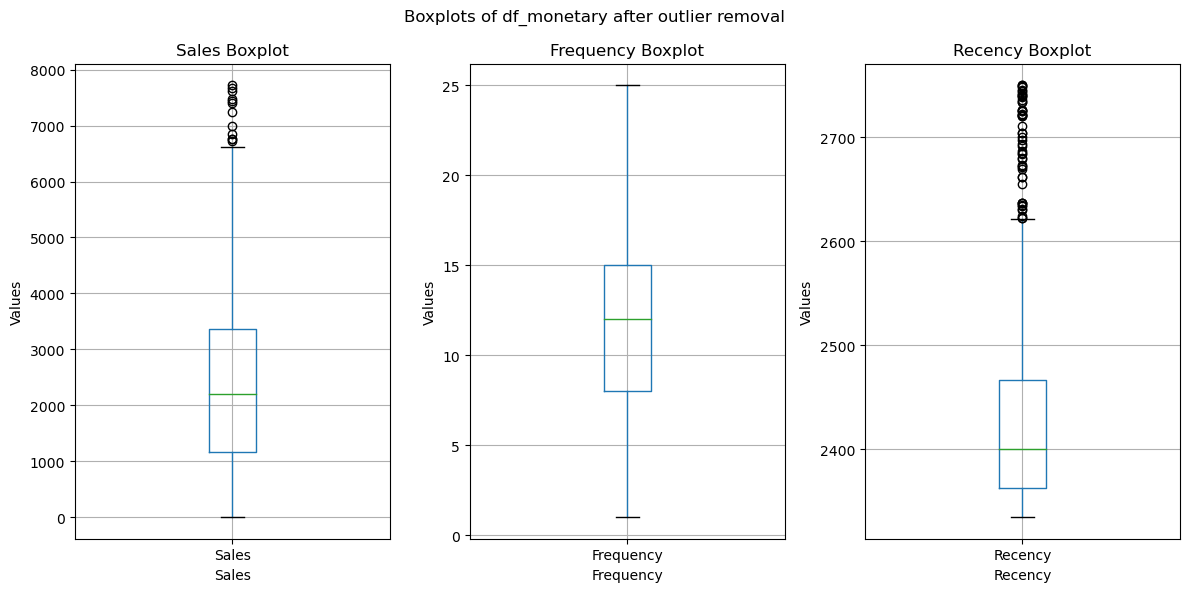

In [20]:
# Assuming you have df_monetary after processing
features_to_plot = ["Sales", "Frequency", "Recency"]
plot_individual_boxplots(df_monetary, features_to_plot, title="Boxplots of df_monetary after outlier removal")


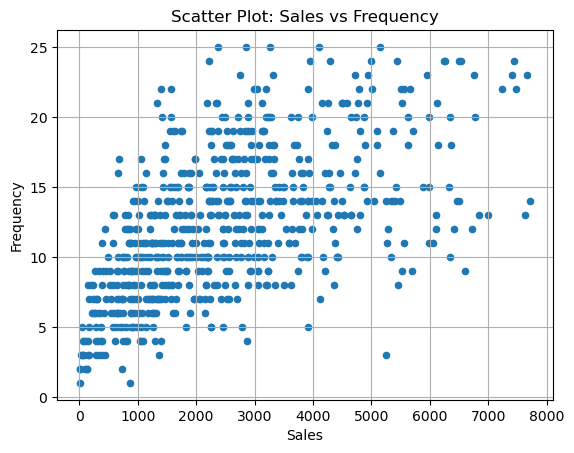

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have df_monetary after processing

features_to_plot = ["Sales", "Frequency", "Recency"]

df_monetary.plot.scatter(x=features_to_plot[0], y=features_to_plot[1])  # First vs Second Feature
plt.title("Scatter Plot: " + features_to_plot[0] + " vs " + features_to_plot[1])
plt.xlabel(features_to_plot[0])
plt.ylabel(features_to_plot[1])
plt.grid(True)
plt.show()

# Repeat for other feature combinations (optional)
# df_monetary.plot.scatter(x=features_to_plot[0], y=features_to_plot[2])
# ... and so on


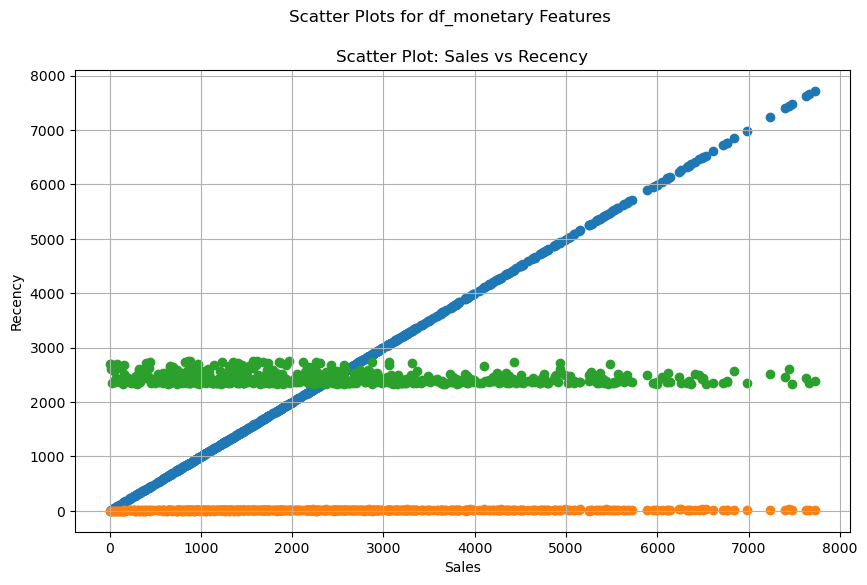

In [31]:

import matplotlib.pyplot as plt

# Assuming you have df_monetary after processing

features_to_plot = ["Sales", "Frequency", "Recency"]

plt.figure(figsize=(10, 6))  # Adjust figure size as needed

for i, feature in enumerate(features_to_plot):
  plt.scatter(df_monetary[features_to_plot[0]], df_monetary[feature])  # Scatter plot for each feature
  plt.xlabel(features_to_plot[0])
  plt.ylabel(feature)
  plt.title(f"Scatter Plot: {features_to_plot[0]} vs {feature}")
  plt.grid(True)

plt.suptitle("Scatter Plots for df_monetary Features")
plt.show()

**Feature scaling**

In [15]:
# Rescaling the attributes
scaling_df = df_monetary[['Sales', 'Frequency', 'Recency']]

# Instantiate
scaler = StandardScaler()

# fit_transform
scaled = scaler.fit_transform(scaling_df)
scaled.shape

scaled = pd.DataFrame(scaled)
scaled.columns = ['Sales', 'Frequency', 'Recency']
scaled.head()

,Sales,Frequency,Recency
0,1.841607,-0.231602,0.826249
1,-0.851017,0.535200,-0.811889
2,-0.412430,-0.039901,1.570857
3,1.556859,1.110301,-0.454477
4,-0.952702,-1.190104,3.119642


**Building the K-means model for clustering**

In [24]:
# k-means with some arbitrary k
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(scaled)
# Assign the labels to each data point, and execute the following script.
kmeans.labels_
label_list=kmeans.labels_
sorted(Counter(label_list).items())

c:\Users\EWF\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


[(0, 103), (1, 108), (2, 245), (3, 207)]

c:\Users\EWF\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\EWF\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\EWF\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\EWF\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with M

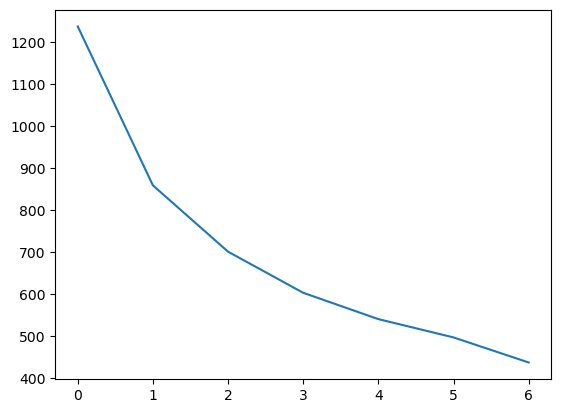

In [25]:
# Elbow-curve /SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(scaled)

    ssd.append(kmeans.inertia_)

# plot the SSDs for each n_clusters
plt.plot(ssd)

In [28]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:

    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(scaled)

    cluster_labels = kmeans.labels_

    # silhouette score
    silhouette_avg = silhouette_score(scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

c:\Users\EWF\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


For n_clusters=2, the silhouette score is 0.34127719611178936
For n_clusters=3, the silhouette score is 0.36377483715337133


c:\Users\EWF\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\EWF\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\EWF\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


For n_clusters=4, the silhouette score is 0.3187892836190986
For n_clusters=5, the silhouette score is 0.3358202491398221


c:\Users\EWF\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


For n_clusters=6, the silhouette score is 0.2704933473919061


c:\Users\EWF\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


For n_clusters=7, the silhouette score is 0.276752665248822


c:\Users\EWF\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


For n_clusters=8, the silhouette score is 0.2803165480940895


In [44]:
# review of the SSE (sum of squares) also known as SSW for the created clusters - internal cohesion 

# smaller value implies better clustering

sse = kmeans.inertia_

print(f"SSE for KMeans clusters: {sse}")

SSE for KMeans clusters: 859.5636085291007


In [49]:
df_monetary.head()

,CustomerID,Sales,Frequency,Recency,Cluster_Id
0,AA-10315,5563.54,11,2519,0
1,AA-10375,1056.36,15,2354,1
2,AA-10480,1790.51,12,2594,2
3,AA-10645,5086.90,18,2390,0
4,AB-10015,886.15,6,2750,2


In [51]:
# calculation of the SSB (sum of squares between) - separation between clusters (external separation)

# larger value implies better clustering

# It is necessary to obtain the centroids before obtaining the SSB

# Drop the Customer_Id column to get only the numeric features
df_numeric = df_monetary.drop(columns=['CustomerID'])

# Perform clustering on the numeric data
kmeans = KMeans(n_clusters=3)  # Example with 3 clusters, adjust as needed
kmeans.fit(df_numeric)

# Obtain the centroids
centroids = kmeans.cluster_centers_

print(f"Shape of centroids: {centroids.shape}")
print(f"Centroids:\n {centroids}")

# Calculate the overall mean of the numeric features
total_mean = df_numeric.mean(axis=0)

# Initialize the SSB (Sum of Squares Between)
ssb = 0

# Calculate the SSB
for centroid in centroids:
    # Calculate the squared distance between the centroid and the overall mean
    distance = np.linalg.norm(centroid - total_mean) ** 2
    # Weight the distance by the number of points in the cluster
    ssb += len(df_numeric) * distance

print(f"Estimated SSB for clusters: {ssb}")


Shape of centroids: (3, 4)
Centroids:
 [[1.05452860e+03 9.25418060e+00 2.45334783e+03 1.20735786e+00]
 [2.85699466e+03 1.37773279e+01 2.42352632e+03 5.66801619e-01]
 [5.33195957e+03 1.64444444e+01 2.41673504e+03 6.83760684e-02]]
Estimated SSB for clusters: 6832519853.3539715


c:\Users\EWF\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.



**K-means model redefinition based on scores**  

In [32]:
# k-means with some arbitrary k
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(scaled)
# Assign the labels to each data point, and execute the following script.
kmeans.labels_
label_list=kmeans.labels_
sorted(Counter(label_list).items())

c:\Users\EWF\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


[(0, 260), (1, 297), (2, 106)]

**K-means model training**

In [33]:
# assign the label
df_monetary['Cluster_Id'] = kmeans.labels_
df_monetary.head()

,CustomerID,Sales,Frequency,Recency,Cluster_Id
0,AA-10315,5563.54,11,2519,0
1,AA-10375,1056.36,15,2354,1
2,AA-10480,1790.51,12,2594,2
3,AA-10645,5086.90,18,2390,0
4,AB-10015,886.15,6,2750,2


**Visualizing results**

<Axes: xlabel='Cluster_Id', ylabel='Recency'>

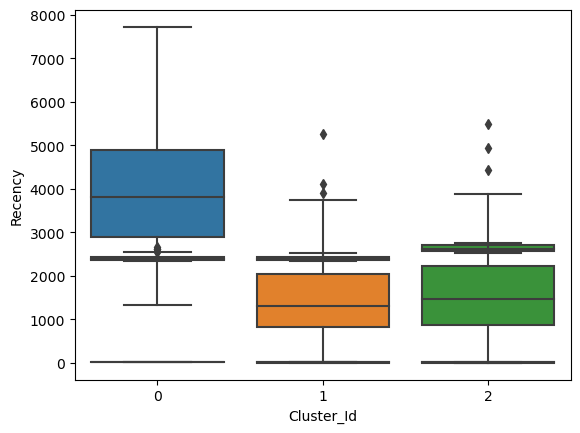

In [37]:
# Box plot to visualize Cluster Id vs Amount
sns.boxplot(x='Cluster_Id', y='Sales', data=df_monetary)

# Box plot to visualize Cluster Id vs Frequency
sns.boxplot(x='Cluster_Id', y='Frequency', data=df_monetary)

# Box plot to visualize Cluster Id vs Recency
sns.boxplot(x='Cluster_Id', y='Recency', data=df_monetary)

In [53]:
import plotly.express as px

# Assuming you have df_monetary, cluster_labels

fig = px.scatter_3d(
    df_monetary,
    x="Sales",  # Replace with your actual x-axis feature name
    y="Frequency",  # Replace with your actual y-axis feature name
    z="Recency",  # Replace with your actual z-axis feature name
    color='Cluster_Id'  # Use the cluster labels variable
)

fig.update_traces(marker=dict(size=6))  # Adjust marker size as desired
fig.show()

In [54]:
import plotly.express as px

# Assuming you have df_monetary, cluster_labels, and a binary "Sex" column

# Define custom marker shapes for male and female
male_marker = dict(symbol="circle", size=6)  # Adjust size as desired
female_marker = dict(symbol="x", size=6, line=dict(width=2))  # Adjust size and line width

# Create the scatter plot with cluster colors
fig = px.scatter_3d(
    df_monetary,
    x="Sales",  # Replace with your actual x-axis feature name
    y="Frequency",  # Replace with your actual y-axis feature name
    z="Recency",  # Replace with your actual z-axis feature name
    color='Cluster_Id'  # Use the cluster labels variable
)

# Update traces with marker selection based on Sex
fig.update_traces(
    selector={"Sex": "M"}, marker=male_marker
)
fig.update_traces(
    selector={"Sex": "F"}, marker=female_marker
)

fig.show()


In [64]:
df_monetary.shape

(663, 5)

In [68]:
merged_df.drop_duplicates(inplace=True)

In [71]:
# Define custom marker shapes for male and female
male_marker = dict(symbol="circle", size=6)  # Adjust size as desired
female_marker = dict(symbol="x", size=6, line=dict(width=2))  # Adjust size and line width

# Create the scatter plot with cluster colors
fig = px.scatter_3d(
    merged_df,
    x="Sales",  # Replace with your actual x-axis feature name
    y="Frequency",  # Replace with your actual y-axis feature name
    z="Recency",  # Replace with your actual z-axis feature name
    color='Cluster_Id'  # Use the cluster labels variable
)

# Update traces with marker selection based on Sex
fig.update_traces(
    selector={"Sex": "M"}, marker=male_marker
)
fig.update_traces(
    selector={"Sex": "F"}, marker=female_marker
)

fig.show()